<a href="https://colab.research.google.com/github/nohasamir89/noha_project/blob/main/Copy_of_TM_vec_Noha_Human_100_sample_PRS_RRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
%pip install git+https://github.com/tymor22/tm-vec.git -q gwpy
%pip install -q SentencePiece transformers
%pip install faiss-cpu

# Import libraries
import torch
from transformers import T5EncoderModel, T5Tokenizer
import numpy as np
import pandas as pd
from tm_vec.embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec.tm_vec_utils import featurize_prottrans, embed_tm_vec, encode
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 78.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the full paths for your files
interacting_path = "/content/drive/My Drive/PRS_filtered.csv"
non_interacting_path = "/content/drive/My Drive/RRS_filtered.csv"

# Verify if the files exist
if os.path.exists(interacting_path):
    print(f"Interacting pairs file found at: {interacting_path}")
else:
    print(f"Warning: Interacting pairs file not found at {interacting_path}")

if os.path.exists(non_interacting_path):
    print(f"Non-interacting pairs file found at: {non_interacting_path}")
else:
    print(f"Warning: Non-interacting pairs file not found at {non_interacting_path}")

print(f"\nSet paths:")
print(f"Interacting pairs file: {interacting_path}")
print(f"Non-interacting pairs file: {non_interacting_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Interacting pairs file found at: /content/drive/My Drive/PRS_filtered.csv
Non-interacting pairs file found at: /content/drive/My Drive/RRS_filtered.csv

Set paths:
Interacting pairs file: /content/drive/My Drive/PRS_filtered.csv
Non-interacting pairs file: /content/drive/My Drive/RRS_filtered.csv


In [ ]:
from google.colab import drive
import torch
from transformers import T5Tokenizer, T5EncoderModel

# Mount Google Drive
drive.mount('/content/drive')

# Load tokenizer and ProtT5 model
print("Loading ProtT5 tokenizer and model...")
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False)
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

# Set up device (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)
model = model.eval()

# Define paths for model files
params_path = "/content/drive/MyDrive/tm_vec_cath_model_params.json"  # Replace with your actual path
model_path = "/content/drive/MyDrive/tm_vec_cath_model.ckpt"    # Replace with your actual path

# Verify if the files exist
if os.path.exists(params_path):
    print(f"Parameters file found at: {params_path}")
else:
    print(f"Warning: Parameters file not found at {params_path}")

if os.path.exists(model_path):
    print(f"Model checkpoint file found at: {model_path}")
else:
    print(f"Warning: Model checkpoint file not found at {model_path}")

# Load TM-Vec model
print("Loading TM-Vec model...")
tm_vec_model_config = trans_basic_block_Config.from_json(params_path)
model_deep = trans_basic_block.load_from_checkpoint(model_path, config=tm_vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

print("All models loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading ProtT5 tokenizer and model...
Using device: cuda:0
Parameters file found at: /content/drive/MyDrive/tm_vec_cath_model_params.json
Model checkpoint file found at: /content/drive/MyDrive/tm_vec_cath_model.ckpt
Loading TM-Vec model...


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/MyDrive/tm_vec_cath_model.ckpt`


All models loaded successfully!


In [ ]:
# Load your data
print("Loading protein pair data...")
interacting_pairs = pd.read_csv(interacting_path)
non_interacting_pairs = pd.read_csv(non_interacting_path)

# Check the column names
print("\nInteracting pairs columns:", interacting_pairs.columns.tolist())
print("Non-interacting pairs columns:", non_interacting_pairs.columns.tolist())

# Display first few rows of each dataframe
print("\nFirst few rows of interacting pairs:")
print(interacting_pairs.head())
print("\nFirst few rows of non-interacting pairs:")
print(non_interacting_pairs.head())

Loading protein pair data...

Interacting pairs columns: ['MSGKASTEGSVTTEFLSDIIGKTVNVKLASGLLYSGRLESIDGFMNVALSSATEHYESNNNKLLNKFNSDVFLRGTQVMYISEQKI', 'MSLPEILPLEVIDKTINQKVLIVLQSNREFEGTLVGFDDFVNVILEDAVEWLIDPEDESRNEKVMQHHGRMLLSGNNIAILVPGGKKTPTEAL']
Non-interacting pairs columns: ['X', 'MSAIPENANVTVLNKNEKKARELIGKLGLKQIPGIIRVTFRKKDNQIYAIEKPEVFRSAGGNYVVFGEAKVDNFTQKLAAAQQQAQASGIMPSNEDVATKSPEDIQADMQAAAEGSVNAAAEEDDEEGEVDAGDLNKDDIELVVQQTNVSKNQAIKALKAHNGDLVNAIMSLSK']

First few rows of interacting pairs:
  MSGKASTEGSVTTEFLSDIIGKTVNVKLASGLLYSGRLESIDGFMNVALSSATEHYESNNNKLLNKFNSDVFLRGTQVMYISEQKI  \
0  MNRQSGVNAGVQNNPPSRVVYLGSIPYDQTEEQILDLCSNVGPVIN...                                       
1  MASIDAFSDLERRMDGFQKDVAQVLARQQNHARQQLQQFQAEMRQL...                                       
2  MKVGGIEDRQLEALKRAALKACELSYSPYSHFRVGCSILTNNDVIF...                                       
3  MDSEVAALVIDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGIMVG...                                       
4  MDSEVAALVIDNGSGMCKAGFAGDDAPRAVFPSIVGRPR


Processing interacting protein pairs...
Processing 96 pairs...
Processing pair 1/96


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


Processing pair 11/96


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


Processing pair 21/96


100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


Processing pair 31/96


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Processing pair 41/96


100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Processing pair 51/96


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Processing pair 61/96


100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


Processing pair 71/96


100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


Processing pair 81/96


100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


Processing pair 91/96


100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Completed 96 interacting pairs

Processing non-interacting protein pairs...
Processing 48 pairs...
Processing pair 1/48


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


Processing pair 11/48


100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Processing pair 21/48


100%|██████████| 1/1 [00:00<00:00, 27.69it/s]


Processing pair 31/48


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


Processing pair 41/48


100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


Completed 48 non-interacting pairs

Creating t-SNE visualization...


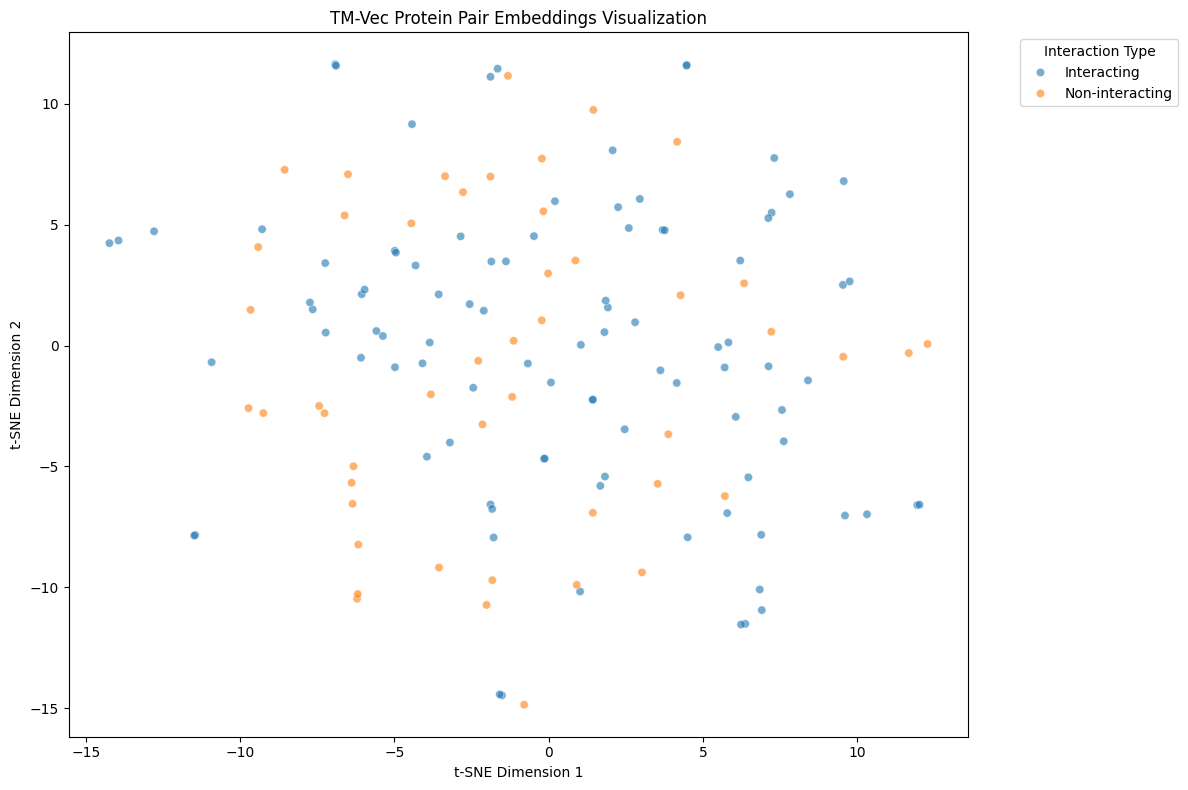


Embedding Statistics:
Number of interacting pairs: 96
Number of non-interacting pairs: 48
Embedding dimension for each pair: 1024


In [ ]:
def process_protein_pairs(df):
    pair_embeddings = []
    seq1_name = df.columns[0]
    seq2_name = df.columns[1]

    print(f"Processing {len(df)} pairs...")

    # Process each pair
    for index, row in df.iterrows():
        if index % 10 == 0:  # Progress update
            print(f"Processing pair {index + 1}/{len(df)}")

        # Get the two protein sequences for this pair
        protein1 = row[seq1_name]
        protein2 = row[seq2_name]

        # Calculate TM-Vec embedding for this specific pair
        embedding1 = encode([protein1], model_deep, model, tokenizer, device)[0]
        embedding2 = encode([protein2], model_deep, model, tokenizer, device)[0]

        # Combine the embeddings for this pair
        pair_embedding = np.concatenate([embedding1, embedding2])
        pair_embeddings.append(pair_embedding)

    return np.array(pair_embeddings)

# Process interacting pairs
print("\nProcessing interacting protein pairs...")
interacting_embeddings = process_protein_pairs(interacting_pairs)
print(f"Completed {len(interacting_embeddings)} interacting pairs")

# Process non-interacting pairs
print("\nProcessing non-interacting protein pairs...")
non_interacting_embeddings = process_protein_pairs(non_interacting_pairs)
print(f"Completed {len(non_interacting_embeddings)} non-interacting pairs")

# Combine all embeddings
all_pair_embeddings = np.vstack([interacting_embeddings, non_interacting_embeddings])
labels = ['Interacting'] * len(interacting_embeddings) + ['Non-interacting'] * len(non_interacting_embeddings)

# Save the results
save_dir = os.path.dirname(interacting_path)
np.save(os.path.join(save_dir, 'protein_pair_embeddings.npy'), all_pair_embeddings)
np.save(os.path.join(save_dir, 'pair_labels.npy'), labels)

# Create t-SNE visualization
print("\nCreating t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
pair_tsne = tsne.fit_transform(all_pair_embeddings)

# Create visualization dataframe
tsne_df = pd.DataFrame(pair_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Interaction'] = labels

# Create the plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Interaction', alpha=0.6)
plt.title('TM-Vec Protein Pair Embeddings Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Add legend with a better location
plt.legend(title='Interaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

# Print embedding statistics
print("\nEmbedding Statistics:")
print(f"Number of interacting pairs: {len(interacting_embeddings)}")
print(f"Number of non-interacting pairs: {len(non_interacting_embeddings)}")
print(f"Embedding dimension for each pair: {all_pair_embeddings.shape[1]}")

Creating t-SNE visualization with new parameters...


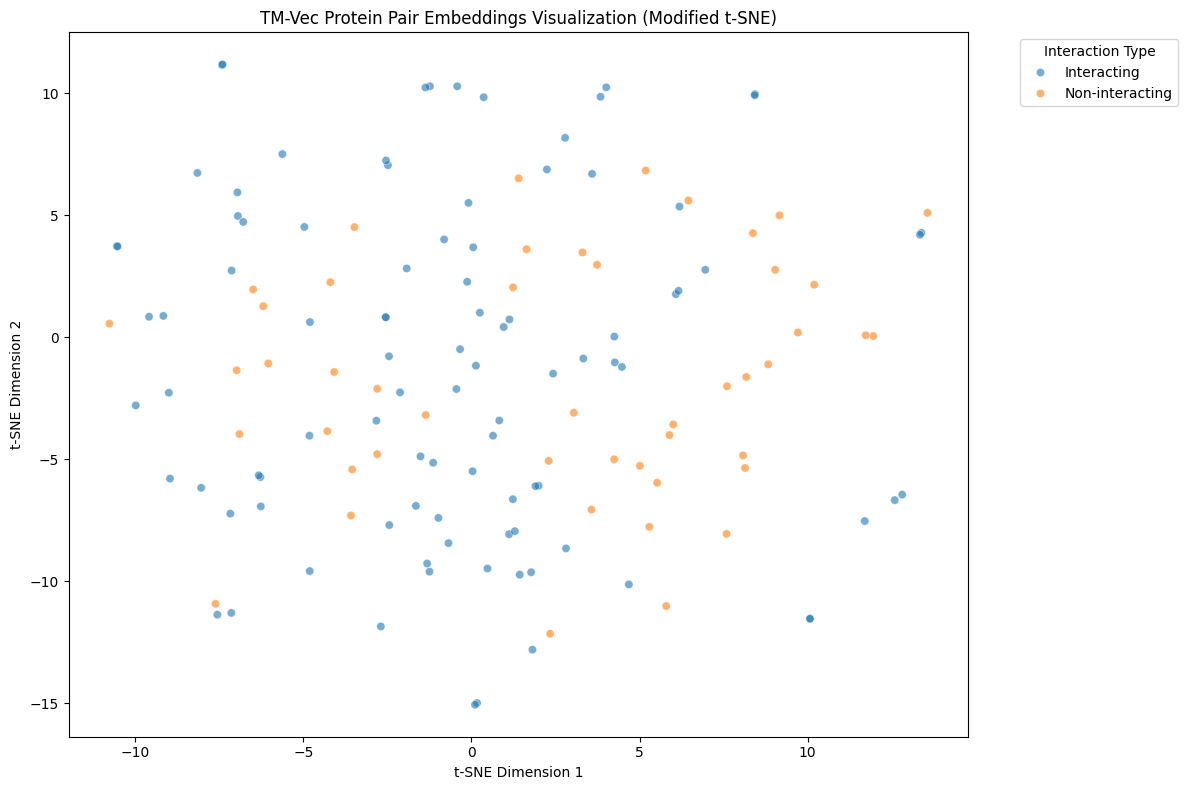


Embedding Statistics:
Number of pairs: 144
Embedding dimension: 1024
Number of interacting pairs: 96
Number of non-interacting pairs: 48


In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the saved embeddings and labels
save_dir = os.path.dirname(interacting_path)
all_pair_embeddings = np.load(os.path.join(save_dir, 'protein_pair_embeddings.npy'))
labels = np.load(os.path.join(save_dir, 'pair_labels.npy'))

# Ensure embeddings are numpy array
if not isinstance(all_pair_embeddings, np.ndarray):
    all_pair_embeddings = all_pair_embeddings.detach().cpu().numpy()

# Create t-SNE with specified parameters
print("Creating t-SNE visualization with new parameters...")
sequence_tsne = TSNE(
    n_components=2,
    learning_rate='auto',
    init='random',
    random_state=42
).fit_transform(all_pair_embeddings)

# Create visualization dataframe
tsne_df = pd.DataFrame(sequence_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Interaction'] = labels

# Create the plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Interaction', alpha=0.6)
plt.title('TM-Vec Protein Pair Embeddings Visualization (Modified t-SNE)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Add legend with a better location
plt.legend(title='Interaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

# Print some basic statistics about the embeddings
print("\nEmbedding Statistics:")
print(f"Number of pairs: {len(all_pair_embeddings)}")
print(f"Embedding dimension: {all_pair_embeddings.shape[1]}")
print(f"Number of interacting pairs: {sum(labels == 'Interacting')}")
print(f"Number of non-interacting pairs: {sum(labels == 'Non-interacting')}")


1. Clustering Analysis:
Silhouette Score: 0.014
Davies-Bouldin Score: 5.061

2. Class Separation Analysis:
Distance between centroids: 3.041


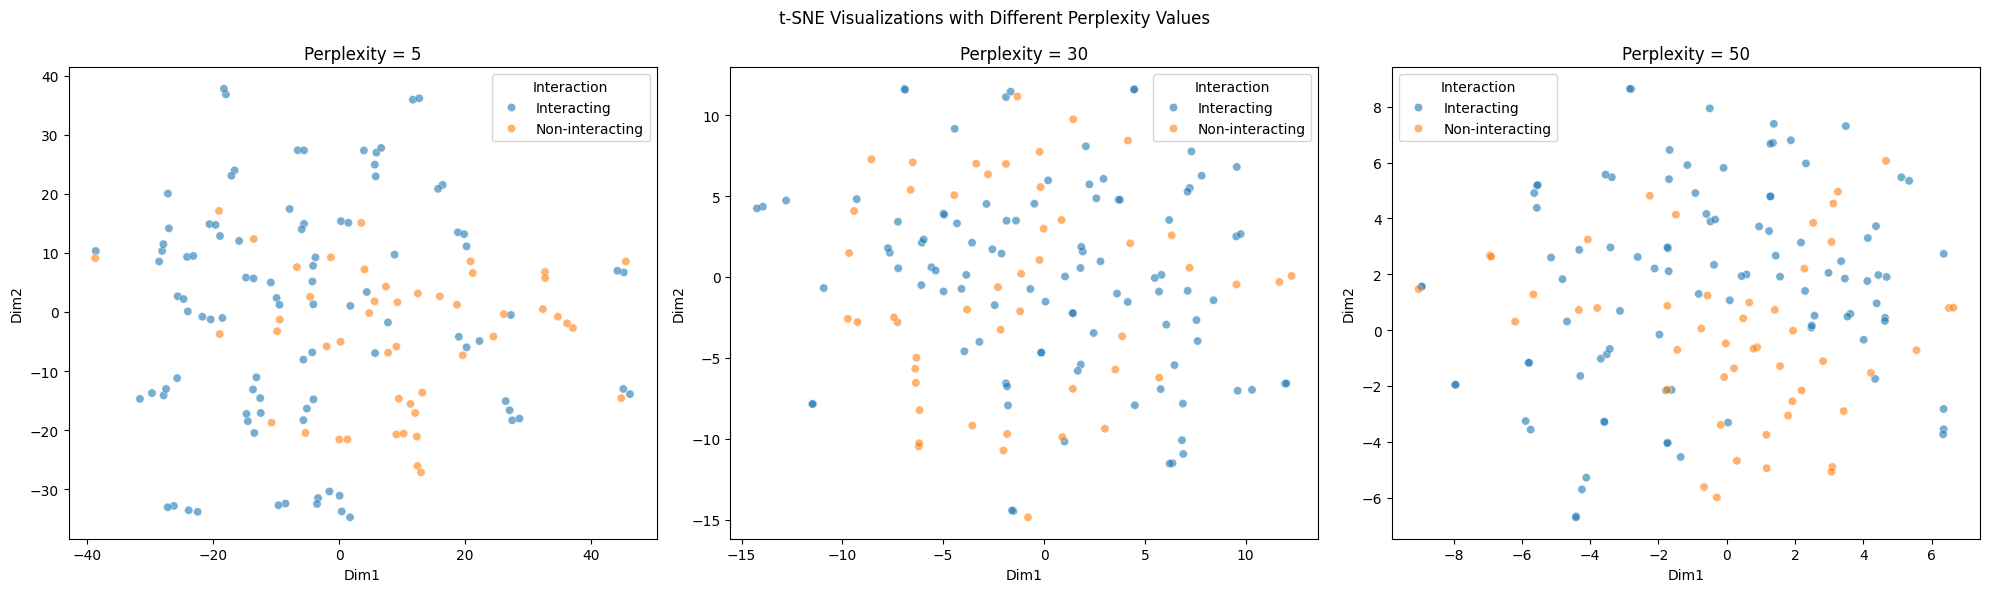

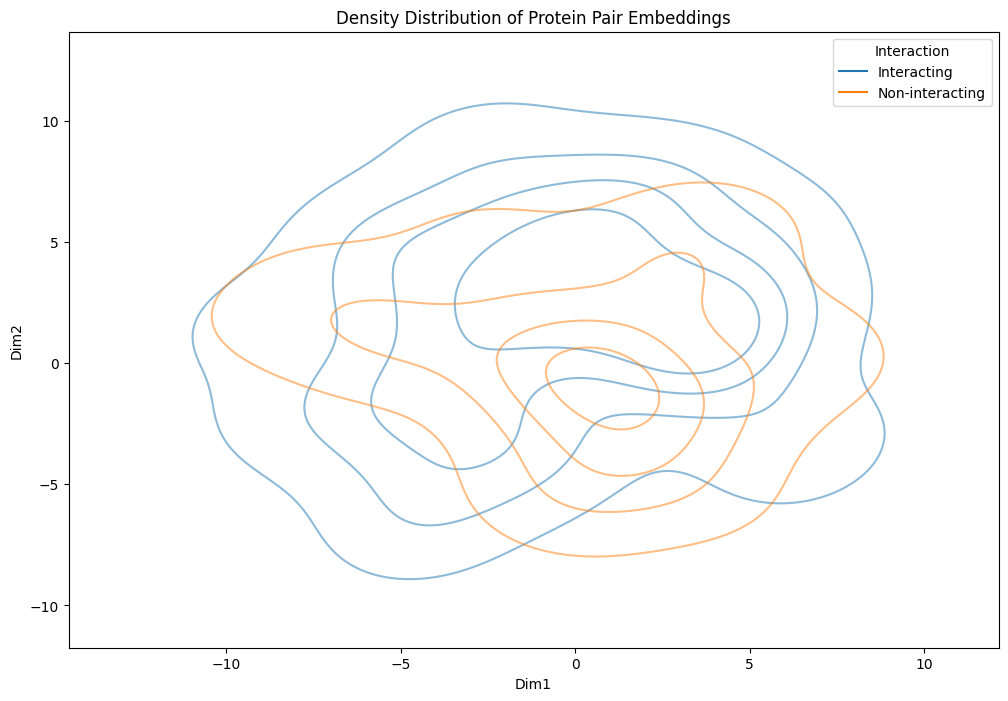


3. Distance Distribution Analysis:


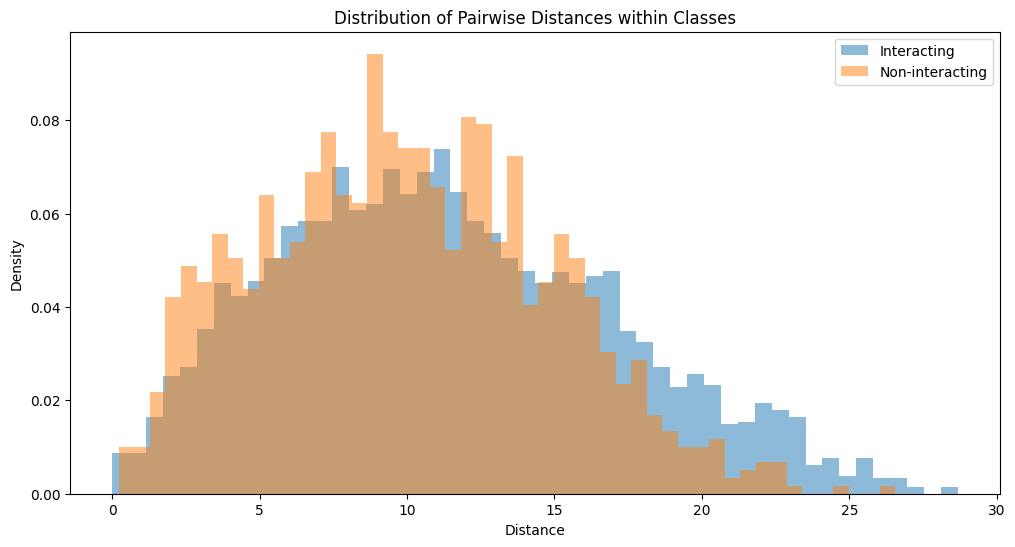


4. Statistical Summary:
Interacting pairs:
Mean distance: 11.363
Std distance: 5.689

Non-interacting pairs:
Mean distance: 9.982
Std distance: 4.826

5. Local Structure Analysis:
Average distance to 5 nearest neighbors:
Interacting: 2.342
Non-interacting: 2.773


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import LabelEncoder
from scipy.spatial import distance
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved data if not already loaded
save_dir = os.path.dirname(interacting_path)
all_pair_embeddings = np.load(os.path.join(save_dir, 'protein_pair_embeddings.npy'))
labels = np.load(os.path.join(save_dir, 'pair_labels.npy'))

# 1. Cluster Analysis
print("\n1. Clustering Analysis:")
# Convert labels to numeric
le = LabelEncoder()
numeric_labels = le.fit_transform(labels)

# Calculate clustering metrics
silhouette_avg = silhouette_score(sequence_tsne, numeric_labels)
db_score = davies_bouldin_score(sequence_tsne, numeric_labels)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")

# 2. Class Separation Statistics
print("\n2. Class Separation Analysis:")
interacting_points = sequence_tsne[labels == 'Interacting']
non_interacting_points = sequence_tsne[labels == 'Non-interacting']

# Calculate centroid distances
centroid_interacting = np.mean(interacting_points, axis=0)
centroid_non_interacting = np.mean(non_interacting_points, axis=0)
centroid_distance = distance.euclidean(centroid_interacting, centroid_non_interacting)

print(f"Distance between centroids: {centroid_distance:.3f}")

# 3. Multiple t-SNE Visualizations with Different Parameters
perplexity_values = [5, 30, 50]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('t-SNE Visualizations with Different Perplexity Values')

for idx, perp in enumerate(perplexity_values):
    tsne_result = TSNE(n_components=2, perplexity=perp, random_state=42).fit_transform(all_pair_embeddings)

    tsne_df = pd.DataFrame(tsne_result, columns=['Dim1', 'Dim2'])
    tsne_df['Interaction'] = labels

    sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Interaction',
                    alpha=0.6, ax=axes[idx])
    axes[idx].set_title(f'Perplexity = {perp}')

plt.tight_layout()
plt.show()

# 4. Density Analysis
plt.figure(figsize=(12, 8))
# Create a kernel density estimation plot
sns.kdeplot(data=tsne_df, x='Dim1', y='Dim2', hue='Interaction',
            levels=5, filled=True, alpha=0.5)
plt.title('Density Distribution of Protein Pair Embeddings')
plt.show()

# 5. Distance Distribution Analysis
print("\n3. Distance Distribution Analysis:")
# Calculate pairwise distances within each class
interacting_distances = distance.pdist(interacting_points)
non_interacting_distances = distance.pdist(non_interacting_points)

plt.figure(figsize=(12, 6))
plt.hist(interacting_distances, bins=50, alpha=0.5, label='Interacting', density=True)
plt.hist(non_interacting_distances, bins=50, alpha=0.5, label='Non-interacting', density=True)
plt.title('Distribution of Pairwise Distances within Classes')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.legend()
plt.show()

# 6. Statistical Summary
print("\n4. Statistical Summary:")
print("Interacting pairs:")
print(f"Mean distance: {np.mean(interacting_distances):.3f}")
print(f"Std distance: {np.std(interacting_distances):.3f}")
print("\nNon-interacting pairs:")
print(f"Mean distance: {np.mean(non_interacting_distances):.3f}")
print(f"Std distance: {np.std(non_interacting_distances):.3f}")

# 7. Local Structure Analysis
k = 5  # number of nearest neighbors to consider
def analyze_local_structure(points, labels):
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(points)
    distances, indices = nbrs.kneighbors(points)
    return distances[:, 1:], indices[:, 1:]

print("\n5. Local Structure Analysis:")
distances_int, indices_int = analyze_local_structure(interacting_points, 'Interacting')
distances_non, indices_non = analyze_local_structure(non_interacting_points, 'Non-interacting')

print(f"Average distance to {k} nearest neighbors:")
print(f"Interacting: {np.mean(distances_int):.3f}")
print(f"Non-interacting: {np.mean(distances_non):.3f}")


Statistical Summary:

Interacting Pairs:
Mean: 0.545
Median: 0.509
Std: 0.189

Non-interacting Pairs:
Mean: 0.427
Median: 0.425
Std: 0.092

Mann-Whitney U test p-value: 3.62e-04


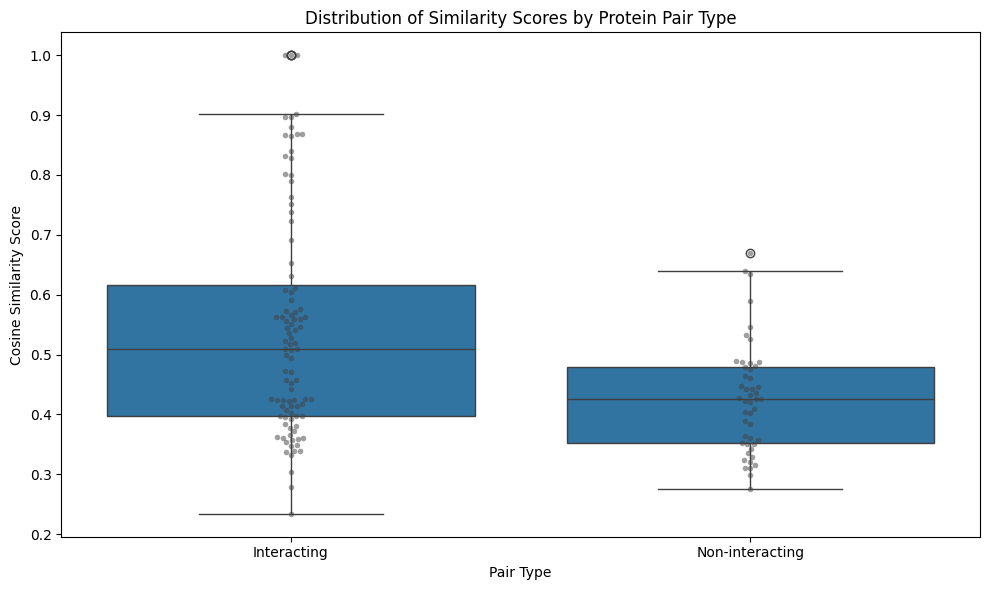

In [ ]:
# Load the saved embeddings if not already loaded
save_dir = os.path.dirname(interacting_path)
all_pair_embeddings = np.load(os.path.join(save_dir, 'protein_pair_embeddings.npy'))
labels = np.load(os.path.join(save_dir, 'pair_labels.npy'))

# Calculate cosine similarity scores for each pair
from sklearn.metrics.pairwise import cosine_similarity

def calculate_pair_similarity(embedding):
    # Split the concatenated embedding back into two protein embeddings
    dim = embedding.shape[0] // 2
    protein1_embed = embedding[:dim]
    protein2_embed = embedding[dim:]

    # Reshape for cosine_similarity function
    protein1_embed = protein1_embed.reshape(1, -1)
    protein2_embed = protein2_embed.reshape(1, -1)

    # Calculate cosine similarity
    similarity = cosine_similarity(protein1_embed, protein2_embed)[0][0]
    return similarity

# Calculate similarities for all pairs
similarities = []
for embedding in all_pair_embeddings:
    similarity = calculate_pair_similarity(embedding)
    similarities.append(similarity)

# Create DataFrame for plotting
similarity_df = pd.DataFrame({
    'Similarity Score': similarities,
    'Pair Type': labels
})

# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=similarity_df, x='Pair Type', y='Similarity Score')
sns.swarmplot(data=similarity_df, x='Pair Type', y='Similarity Score', color='0.25', alpha=0.5, size=4)

plt.title('Distribution of Similarity Scores by Protein Pair Type')
plt.xlabel('Pair Type')
plt.ylabel('Cosine Similarity Score')

# Add statistical annotations
from scipy import stats
interacting_scores = similarity_df[similarity_df['Pair Type'] == 'Interacting']['Similarity Score']
non_interacting_scores = similarity_df[similarity_df['Pair Type'] == 'Non-interacting']['Similarity Score']
statistic, pvalue = stats.mannwhitneyu(interacting_scores, non_interacting_scores)

# Print statistics
print("\nStatistical Summary:")
print("\nInteracting Pairs:")
print(f"Mean: {interacting_scores.mean():.3f}")
print(f"Median: {interacting_scores.median():.3f}")
print(f"Std: {interacting_scores.std():.3f}")

print("\nNon-interacting Pairs:")
print(f"Mean: {non_interacting_scores.mean():.3f}")
print(f"Median: {non_interacting_scores.median():.3f}")
print(f"Std: {non_interacting_scores.std():.3f}")

print(f"\nMann-Whitney U test p-value: {pvalue:.2e}")

plt.tight_layout()
plt.show()

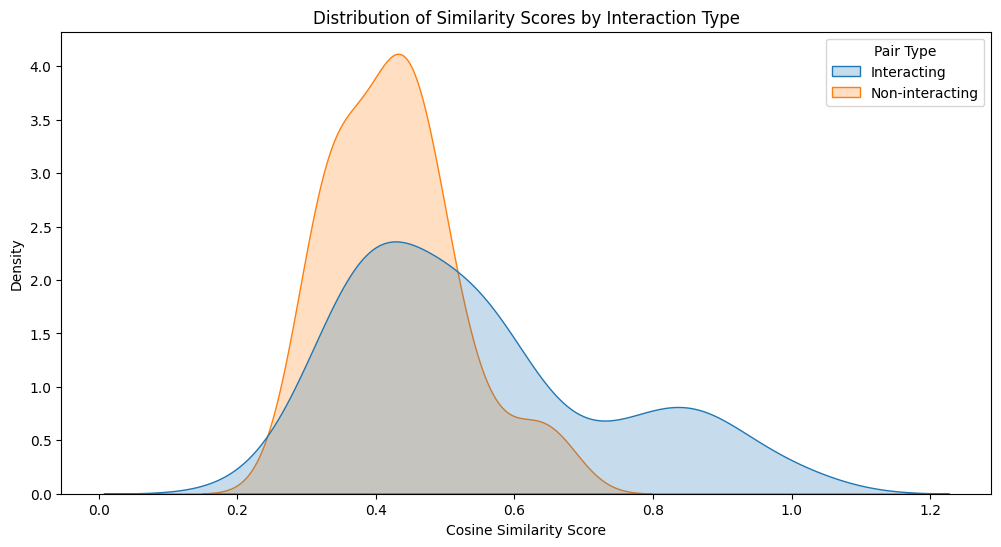

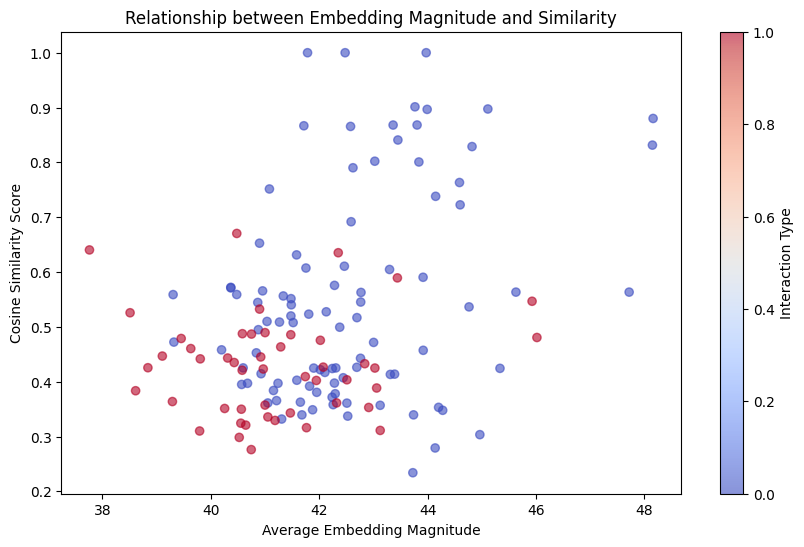

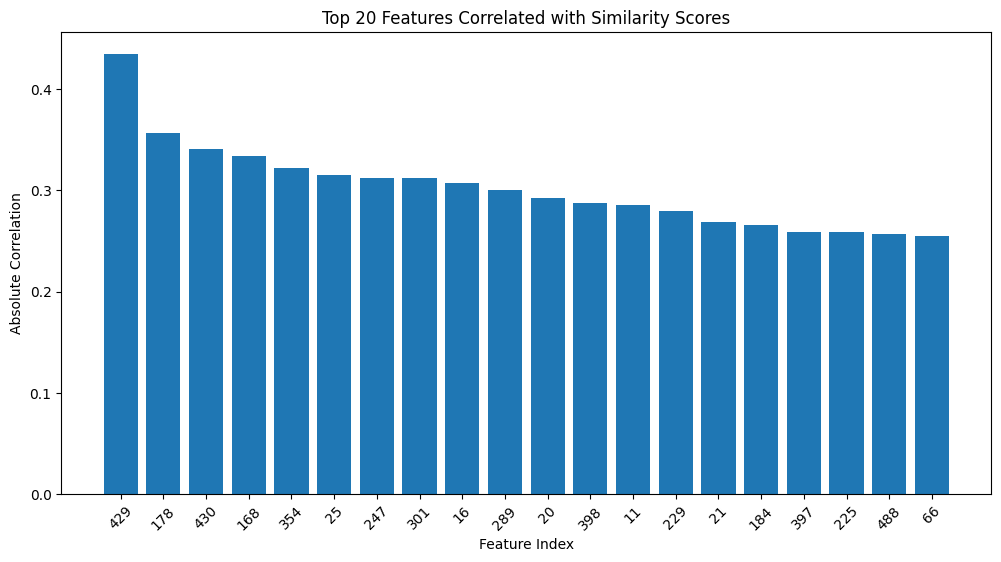

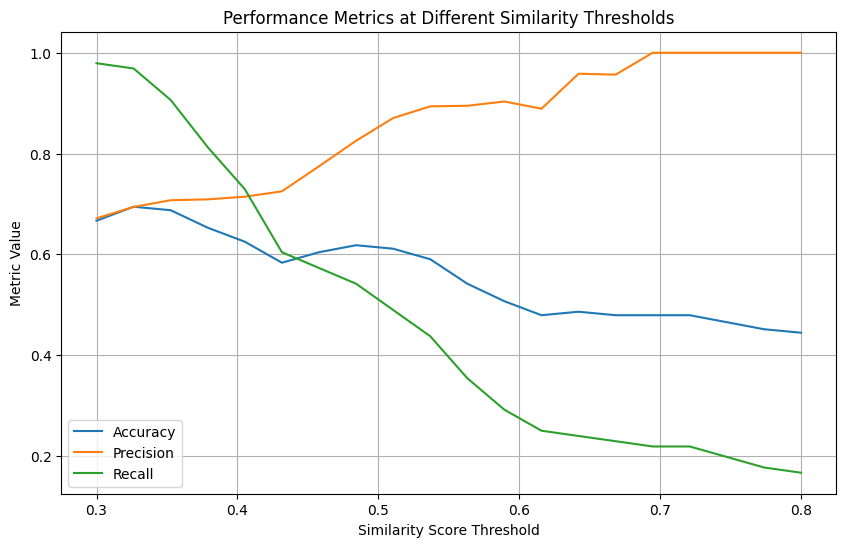


Detailed Statistical Analysis:

Similarity Score Ranges:

Interacting Pairs:
Min: 0.234
Max: 1.000
25th percentile: 0.397
75th percentile: 0.616
Interquartile Range: 0.218

Non-interacting Pairs:
Min: 0.276
Max: 0.670
25th percentile: 0.353
75th percentile: 0.479
Interquartile Range: 0.127


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# 1. Distribution Plot of Similarity Scores
plt.figure(figsize=(12, 6))
sns.kdeplot(data=similarity_df, x='Similarity Score', hue='Pair Type', fill=True, common_norm=False)
plt.title('Distribution of Similarity Scores by Interaction Type')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Density')
plt.show()

# 2. Scatter Plot of Embedding Dimensions vs Similarity
def plot_embedding_vs_similarity():
    # Calculate embedding magnitudes for each protein in the pair
    magnitudes = []
    for embedding in all_pair_embeddings:
        dim = embedding.shape[0] // 2
        protein1_mag = np.linalg.norm(embedding[:dim])
        protein2_mag = np.linalg.norm(embedding[dim:])
        magnitudes.append((protein1_mag + protein2_mag)/2)

    plt.figure(figsize=(10, 6))
    plt.scatter(magnitudes, similarities, c=[0 if x == 'Interacting' else 1 for x in labels],
                alpha=0.6, cmap='coolwarm')
    plt.colorbar(label='Interaction Type')
    plt.xlabel('Average Embedding Magnitude')
    plt.ylabel('Cosine Similarity Score')
    plt.title('Relationship between Embedding Magnitude and Similarity')
    plt.show()

plot_embedding_vs_similarity()

# 3. Correlation Analysis
def analyze_similarity_correlations():
    dim = all_pair_embeddings.shape[1] // 2
    correlations = []
    for i in range(dim):
        protein1_feature = all_pair_embeddings[:, i]
        protein2_feature = all_pair_embeddings[:, i + dim]
        corr = np.corrcoef(protein1_feature, similarities)[0,1]
        correlations.append(abs(corr))

    # Plot top correlating features
    plt.figure(figsize=(12, 6))
    top_k = 20  # Show top 20 correlating features
    top_correlations = sorted(enumerate(correlations), key=lambda x: abs(x[1]), reverse=True)[:top_k]
    feature_ids, corr_values = zip(*top_correlations)

    plt.bar(range(top_k), corr_values)
    plt.title('Top 20 Features Correlated with Similarity Scores')
    plt.xlabel('Feature Index')
    plt.ylabel('Absolute Correlation')
    plt.xticks(range(top_k), feature_ids, rotation=45)
    plt.show()

analyze_similarity_correlations()

# 4. Similarity Score Thresholding Analysis
def analyze_threshold_performance():
    thresholds = np.linspace(0.3, 0.8, 20)
    accuracy = []
    precision = []
    recall = []

    for threshold in thresholds:
        predicted_interactions = similarities >= threshold
        true_interactions = labels == 'Interacting'

        # Calculate metrics
        acc = np.mean(predicted_interactions == true_interactions)
        prec = np.sum(predicted_interactions & true_interactions) / (np.sum(predicted_interactions) + 1e-10)
        rec = np.sum(predicted_interactions & true_interactions) / (np.sum(true_interactions) + 1e-10)

        accuracy.append(acc)
        precision.append(prec)
        recall.append(rec)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracy, label='Accuracy')
    plt.plot(thresholds, precision, label='Precision')
    plt.plot(thresholds, recall, label='Recall')
    plt.xlabel('Similarity Score Threshold')
    plt.ylabel('Metric Value')
    plt.title('Performance Metrics at Different Similarity Thresholds')
    plt.legend()
    plt.grid(True)
    plt.show()

analyze_threshold_performance()

# Print summary statistics
print("\nDetailed Statistical Analysis:")
print("\nSimilarity Score Ranges:")
for pair_type in ['Interacting', 'Non-interacting']:
    scores = similarity_df[similarity_df['Pair Type'] == pair_type]['Similarity Score']
    print(f"\n{pair_type} Pairs:")
    print(f"Min: {scores.min():.3f}")
    print(f"Max: {scores.max():.3f}")
    print(f"25th percentile: {scores.quantile(0.25):.3f}")
    print(f"75th percentile: {scores.quantile(0.75):.3f}")
    print(f"Interquartile Range: {scores.quantile(0.75) - scores.quantile(0.25):.3f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.6 MB/s eta 0:00:00
Creating UMAP visualization...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


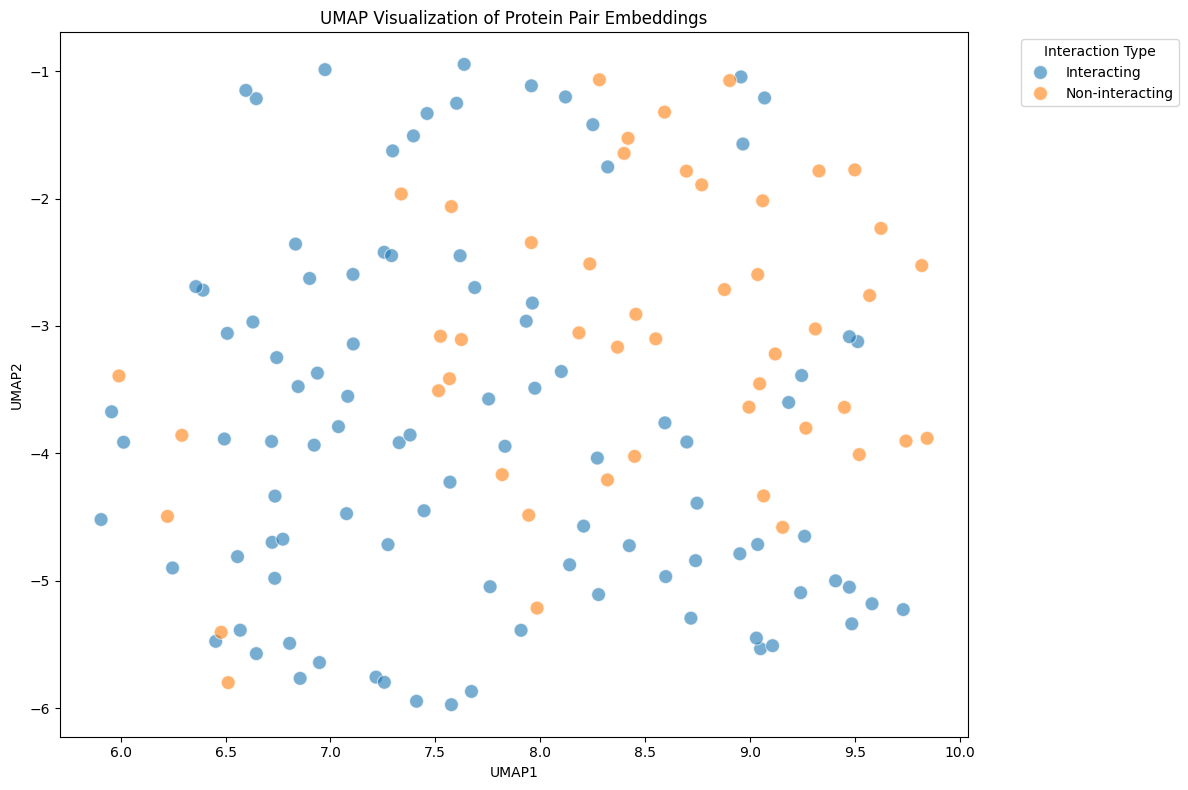


UMAP Embedding Statistics:

Interacting Pairs:
UMAP1 range: [5.91, 9.73]
UMAP2 range: [-5.97, -0.95]

Non-interacting Pairs:
UMAP1 range: [5.99, 9.85]
UMAP2 range: [-5.80, -1.07]


In [ ]:
# Install UMAP
!pip install umap-learn

# Now run the UMAP visualization code
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the saved embeddings if not already loaded
save_dir = os.path.dirname(interacting_path)
all_pair_embeddings = np.load(os.path.join(save_dir, 'protein_pair_embeddings.npy'))
labels = np.load(os.path.join(save_dir, 'pair_labels.npy'))

# Create UMAP embedding
print("Creating UMAP visualization...")
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)
umap_embeddings = reducer.fit_transform(all_pair_embeddings)

# Create DataFrame for plotting
umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])
umap_df['Interaction'] = labels

# Create the plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=umap_df,
    x='UMAP1',
    y='UMAP2',
    hue='Interaction',
    alpha=0.6,
    s=100  # Point size
)

plt.title('UMAP Visualization of Protein Pair Embeddings')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Add legend with a better location
plt.legend(title='Interaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

# Print some statistics about the UMAP embeddings
print("\nUMAP Embedding Statistics:")
for pair_type in ['Interacting', 'Non-interacting']:
    subset = umap_df[umap_df['Interaction'] == pair_type]
    print(f"\n{pair_type} Pairs:")
    print(f"UMAP1 range: [{subset['UMAP1'].min():.2f}, {subset['UMAP1'].max():.2f}]")
    print(f"UMAP2 range: [{subset['UMAP2'].min():.2f}, {subset['UMAP2'].max():.2f}]")


Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.74      1.00      0.85        20

    accuracy                           0.76        29
   macro avg       0.87      0.61      0.61        29
weighted avg       0.82      0.76      0.70        29


Training SVM...

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.69      1.00      0.82        20

    accuracy                           0.69        29
   macro avg       0.34      0.50      0.41        29
weighted avg       0.48      0.69      0.56        29


Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71         9
           1       0.86      0.90      0.88       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


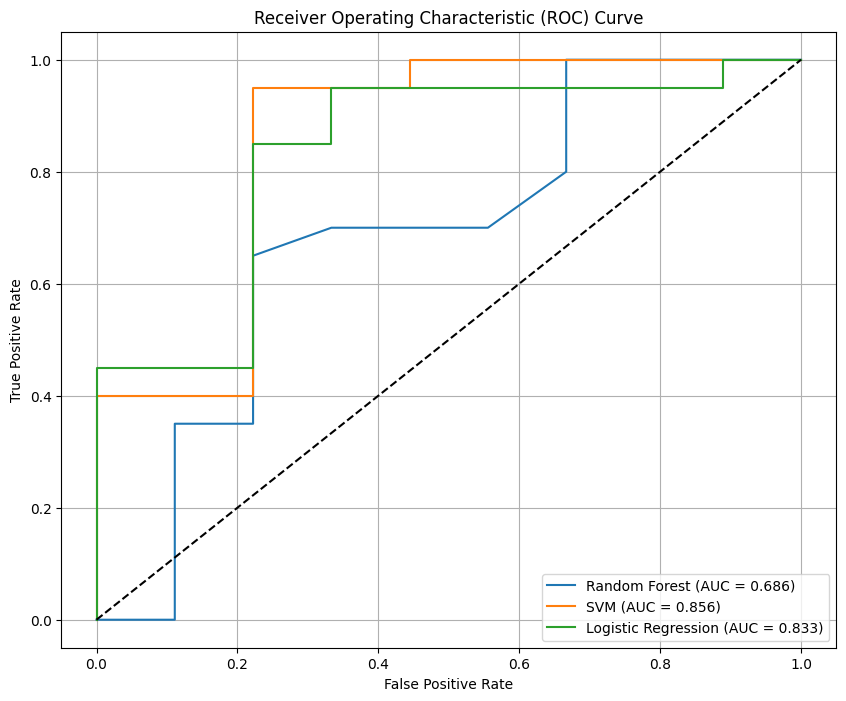

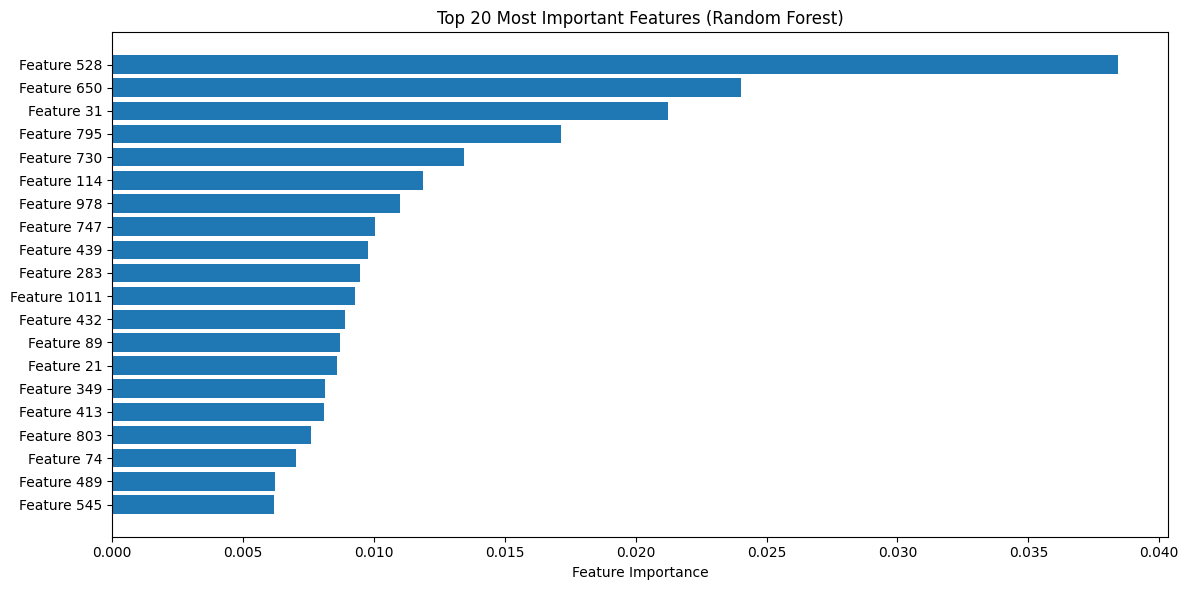


Top 10 Most Important Features:
Feature 528: 0.0384
Feature 650: 0.0240
Feature 31: 0.0213
Feature 795: 0.0172
Feature 730: 0.0134
Feature 114: 0.0119
Feature 978: 0.0110
Feature 747: 0.0101
Feature 439: 0.0098
Feature 283: 0.0095


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
# Load embeddings and labels if not already loaded
save_dir = os.path.dirname(interacting_path)
all_pair_embeddings = np.load(os.path.join(save_dir, 'protein_pair_embeddings.npy'))
labels = np.load(os.path.join(save_dir, 'pair_labels.npy'))

# Calculate similarity scores if not already done
def calculate_pair_similarity(embedding):
    dim = embedding.shape[0] // 2
    protein1_embed = embedding[:dim]
    protein2_embed = embedding[dim:]
    protein1_embed = protein1_embed.reshape(1, -1)
    protein2_embed = protein2_embed.reshape(1, -1)
    return cosine_similarity(protein1_embed, protein2_embed)[0][0]

similarities = np.array([calculate_pair_similarity(embedding) for embedding in all_pair_embeddings])

# Combine embeddings with similarity scores
X = np.column_stack((all_pair_embeddings, similarities))

# Convert labels to numeric
y = (labels == 'Interacting').astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42)
}

# Train and evaluate classifiers
plt.figure(figsize=(10, 8))

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train_scaled, y_train)

    # Predict probabilities
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
    y_pred = clf.predict(X_test_scaled)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Feature importance analysis for Random Forest
rf_clf = classifiers['Random Forest']
feature_importance = rf_clf.feature_importances_

# Plot top 20 most important features
plt.figure(figsize=(12, 6))
top_features = np.argsort(feature_importance)[-20:]
plt.barh(range(20), feature_importance[top_features])
plt.yticks(range(20), [f'Feature {i}' for i in top_features])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

# Print best features and their importance scores
print("\nTop 10 Most Important Features:")
for i in reversed(top_features[-10:]):
    print(f"Feature {i}: {feature_importance[i]:.4f}")

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Print results for each model
def print_model_results(grid, model_name, X_test, y_test):
    print(f"\n{model_name} Results:")
    print("Best parameters:")
    print(grid.best_params_)

    print(f"\nBest CV score: {grid.best_score_:.3f}")

    # Test set predictions and performance
    y_pred = grid.predict(X_test)
    print("\nTest set performance:")
    print(classification_report(y_test, y_pred))

# Create ROC curve plot
plt.figure(figsize=(10, 8))

# For SVM
print_model_results(svm_grid, "SVM", X_test, y_test)
y_pred_proba_svm = svm_grid.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'Optimized SVM (AUC = {roc_auc_svm:.3f})')

# For Logistic Regression
print_model_results(lr_grid, "Logistic Regression", X_test, y_test)
y_pred_proba_lr = lr_grid.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Optimized LR (AUC = {roc_auc_lr:.3f})')

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Optimized Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Save the best models
import joblib
joblib.dump(svm_grid.best_estimator_, 'best_svm_model.pkl')
joblib.dump(lr_grid.best_estimator_, 'best_lr_model.pkl')

# Print feature importance for Logistic Regression
if hasattr(lr_grid.best_estimator_, 'named_steps'):
    lr_coef = lr_grid.best_estimator_.named_steps['lr'].coef_[0]
    feature_importance = np.abs(lr_coef)

    # Plot top 20 most important features
    plt.figure(figsize=(12, 6))
    top_features = np.argsort(feature_importance)[-20:]
    plt.barh(range(20), feature_importance[top_features])
    plt.yticks(range(20), [f'Feature {i}' for i in top_features])
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Top 20 Most Important Features (Logistic Regression)')
    plt.tight_layout()
    plt.show()

NameError: name 'svm_grid' is not defined

<Figure size 1000x800 with 0 Axes>

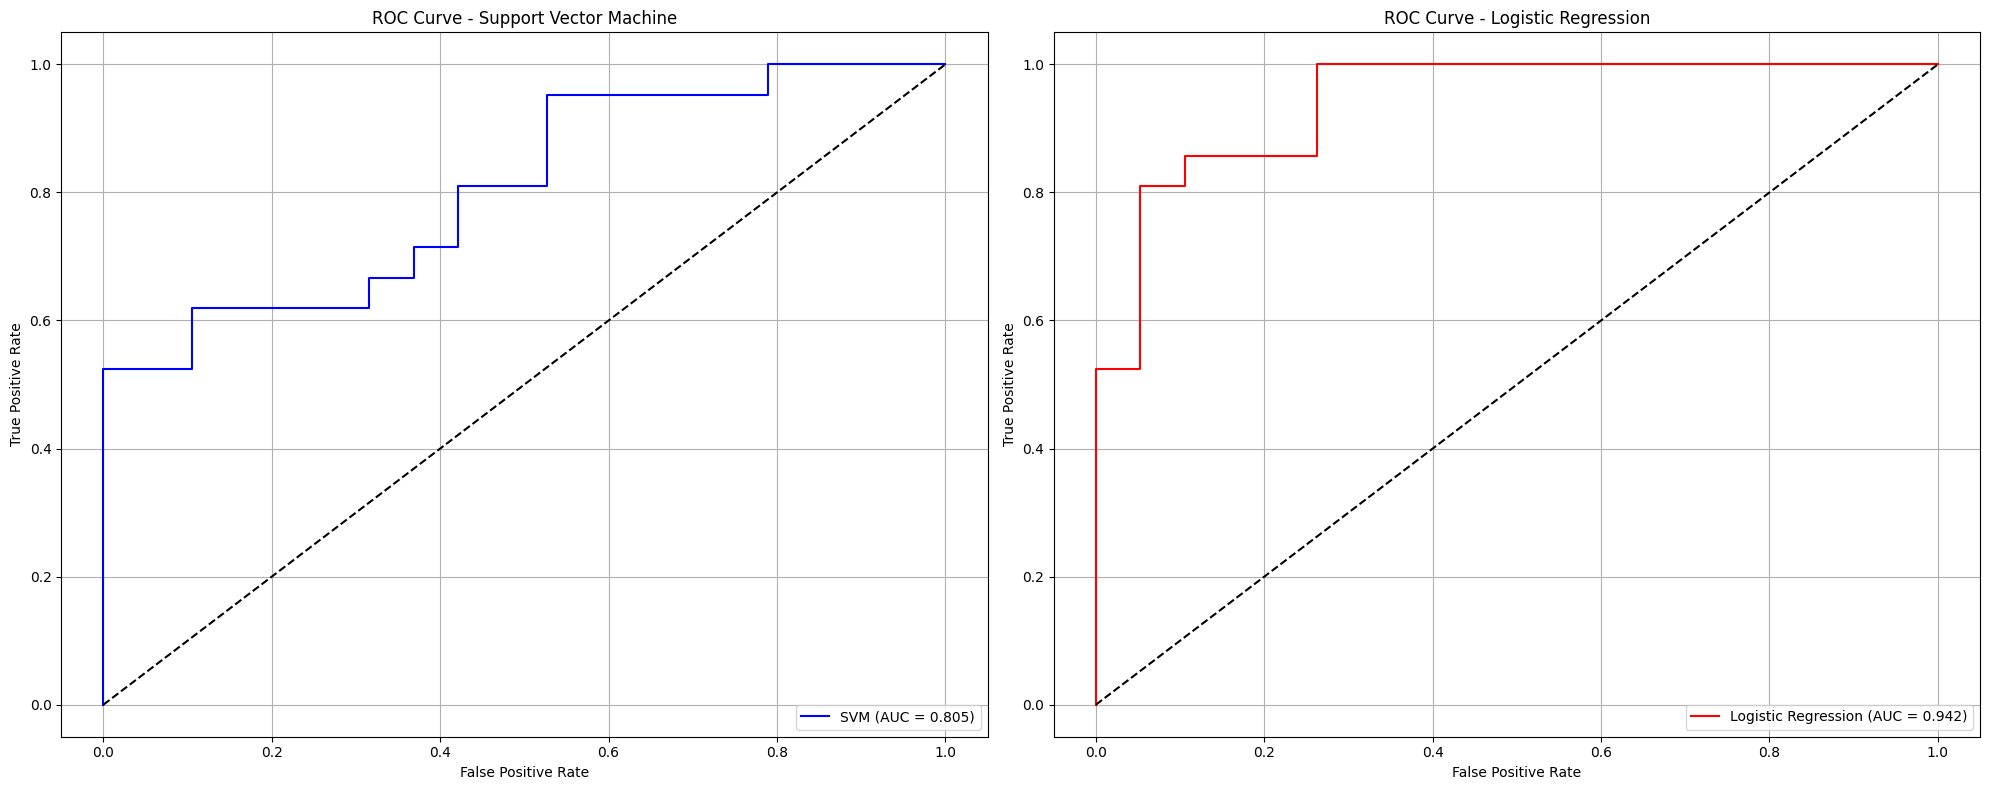


Model Performance Comparison:

Support Vector Machine:
AUC-ROC Score: 0.805

Logistic Regression:
AUC-ROC Score: 0.942


In [ ]:
# Create two separate plots for ROC curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot for optimized SVM
y_pred_proba_svm = svm_grid.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

ax1.plot(fpr_svm, tpr_svm, color='blue', label=f'SVM (AUC = {roc_auc_svm:.3f})')
ax1.plot([0, 1], [0, 1], 'k--')  # diagonal line
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - Support Vector Machine')
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot for optimized Logistic Regression
y_pred_proba_lr = lr_grid.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

ax2.plot(fpr_lr, tpr_lr, color='red', label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')
ax2.plot([0, 1], [0, 1], 'k--')  # diagonal line
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve - Logistic Regression')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print performance comparison
print("\nModel Performance Comparison:")
print("\nSupport Vector Machine:")
print(f"AUC-ROC Score: {roc_auc_svm:.3f}")

print("\nLogistic Regression:")
print(f"AUC-ROC Score: {roc_auc_lr:.3f}")

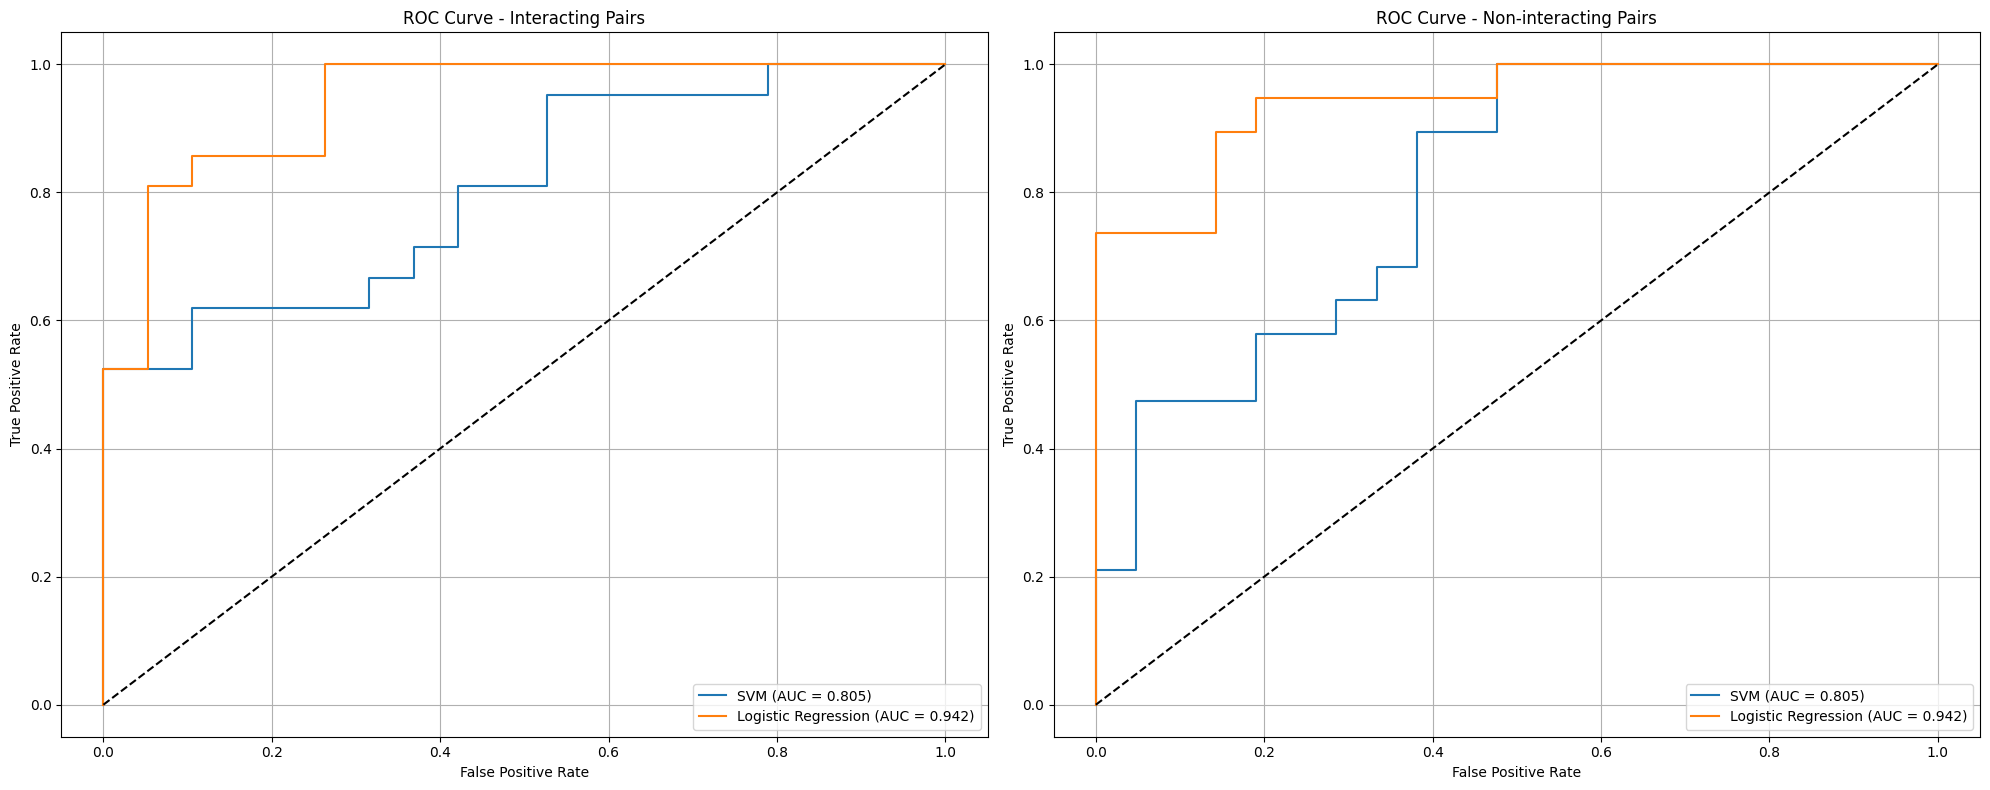


SVM Performance:
Interacting pairs AUC: 0.805
Non-interacting pairs AUC: 0.805

Logistic Regression Performance:
Interacting pairs AUC: 0.942
Non-interacting pairs AUC: 0.942


In [ ]:
# Plot ROC curves separately for interacting and non-interacting classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# For both SVM and Logistic Regression
for model_name, model in [("SVM", svm_grid), ("Logistic Regression", lr_grid)]:
    # Get probabilities
    y_pred_proba = model.predict_proba(X_test)

    # ROC curve for interacting class (class 1)
    fpr_int, tpr_int, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)
    roc_auc_int = auc(fpr_int, tpr_int)

    # ROC curve for non-interacting class (class 0)
    fpr_nonint, tpr_nonint, _ = roc_curve(y_test, y_pred_proba[:, 0], pos_label=0)
    roc_auc_nonint = auc(fpr_nonint, tpr_nonint)

    # Plot for interacting pairs
    ax1.plot(fpr_int, tpr_int,
             label=f'{model_name} (AUC = {roc_auc_int:.3f})')

    # Plot for non-interacting pairs
    ax2.plot(fpr_nonint, tpr_nonint,
             label=f'{model_name} (AUC = {roc_auc_nonint:.3f})')

# Customize interacting plot
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - Interacting Pairs')
ax1.legend(loc='lower right')
ax1.grid(True)

# Customize non-interacting plot
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve - Non-interacting Pairs')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print detailed performance metrics for each class
for model_name, model in [("SVM", svm_grid), ("Logistic Regression", lr_grid)]:
    print(f"\n{model_name} Performance:")
    y_pred_proba = model.predict_proba(X_test)

    # For interacting class
    roc_auc_int = auc(
        *roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)[:2]
    )

    # For non-interacting class
    roc_auc_nonint = auc(
        *roc_curve(y_test, y_pred_proba[:, 0], pos_label=0)[:2]
    )

    print(f"Interacting pairs AUC: {roc_auc_int:.3f}")
    print(f"Non-interacting pairs AUC: {roc_auc_nonint:.3f}")

In [ ]:
# Print the save directory and full paths
save_dir = os.path.dirname(interacting_path)
print("Save directory:", save_dir)
print("\nFull paths:")
print("Embeddings:", os.path.join(save_dir, 'protein_pair_embeddings.npy'))
print("Labels:", os.path.join(save_dir, 'pair_labels.npy'))

Save directory: /content/drive/My Drive

Full paths:
Embeddings: /content/drive/My Drive/protein_pair_embeddings.npy
Labels: /content/drive/My Drive/pair_labels.npy


In [ ]:
# Create network files for Cytoscape
import pandas as pd

# Load your data
interacting_pairs = pd.read_csv(interacting_path)
non_interacting_pairs = pd.read_csv(non_interacting_path)

# Create SIF file (Simple Interaction Format)
with open('protein_interactions.sif', 'w') as f:
    # Write interacting pairs
    for _, row in interacting_pairs.iterrows():
        protein1 = row[interacting_pairs.columns[0]]
        protein2 = row[interacting_pairs.columns[1]]
        f.write(f"{protein1} interacts {protein2}\n")

# Create CSV with more detailed information
network_data = []

# Add interacting pairs
for _, row in interacting_pairs.iterrows():
    network_data.append({
        'Source': row[interacting_pairs.columns[0]],
        'Target': row[interacting_pairs.columns[1]],
        'Interaction_Type': 'Interacting',
        'Interaction_Score': 1
    })

# Add non-interacting pairs
for _, row in non_interacting_pairs.iterrows():
    network_data.append({
        'Source': row[non_interacting_pairs.columns[0]],
        'Target': row[non_interacting_pairs.columns[1]],
        'Interaction_Type': 'Non-interacting',
        'Interaction_Score': 0
    })

# Create DataFrame and save to CSV
network_df = pd.DataFrame(network_data)
network_df.to_csv('protein_network_human.csv', index=False)

print("Files created for Cytoscape visualization:")
print("1. protein_interactions.sif")
print("2. protein_network_human.csv")

print("\nTo visualize in Cytoscape:")
print("1. Open Cytoscape")
print("2. File → Import → Network from File...")
print("3. Select either protein_interactions.sif or protein_network.csv")
print("4. For the CSV file, make sure to specify:")
print("   - 'Source' column as source nodes")
print("   - 'Target' column as target nodes")
print("   - 'Interaction_Type' can be used for edge colors")
print("   - 'Interaction_Score' can be used for edge width")

Files created for Cytoscape visualization:
1. protein_interactions.sif
2. protein_network_human.csv

To visualize in Cytoscape:
1. Open Cytoscape
2. File → Import → Network from File...
3. Select either protein_interactions.sif or protein_network.csv
4. For the CSV file, make sure to specify:
   - 'Source' column as source nodes
   - 'Target' column as target nodes
   - 'Interaction_Type' can be used for edge colors
   - 'Interaction_Score' can be used for edge width
